In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
pip install pydicom

     |████████████████████████████████| 2.0 MB 22.3 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [3]:
import sys
sys.path.append("../utils/")
sys.path.append("../model/")
import os
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from pathlib import Path
import seaborn as sns
from dicom_table import DicomTable
from pydicom import read_file, dcmread
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib
from map import Map
from thickness_map import Map
from etdrs_utils import ETDRSUtils
from helper_functions import transform_dcm_to_npy_3d, transform_segmentation_to_npy_3d, get_meta, try_open_dcm, get_all_dcm_meta
from models_network_deep import backbone_network



Matplotlib is building the font cache; this may take a moment.


## Get Paths

In [4]:
dicom_healhty_path = str(Path(os.getcwd()).parent.parent / 
                         "dicom_files_healthy" / 
                         "dicom_files_healthy" / 
                         "Eckardt-Franzi_Cert1_20010101_20230320_0901_Spectralis_Bild_OD_1.3.6.1.4.1.33437.10.4.16073696.13323773030.33687.4.1.dcm")

dicom_diseased_path = str(Path(os.getcwd()).parent.parent / 
                         "dicom_irds" / 
                         "DICOM Robin 14.9" / 
                         "17_19651217_20210927_1116_Spectralis_Bild_OD_1.3.6.1.4.1.33437.10.4.9457825.13277207924.9378.4.1.dcm")

FIG_DIR = Path(os.getcwd()).parent / "figures" / "thickness_maps"
FIG_DIR.mkdir(parents=True, exist_ok=True)

onl_replace = {1:0, 2:1, 3:0}

healthy_np = np.array(read_file(dicom_healhty_path).pixel_array)
diseased_np = np.array(read_file(dicom_diseased_path).pixel_array)

In [5]:
dicom_healthy = DicomTable(dicom_healhty_path)
dicom_diseased = DicomTable(dicom_diseased_path)

## Get trained models predictions

In [6]:
model_healthy = backbone_network(pretrained_weights="../../retina-segmentation/trained_models_checkpoint/healthy_all_CE", IMG_WIDTH=512, IMG_HEIGHT=496, IMG_CHANNELS=1, 
                             n_classes=4, last_activation="softmax",
                             need_complie=True,
                             BN_list=[True]*14,
                             droprate=0.0,
                             NL_att=False,
                             momentum=0.9)

pred_healthy = model_healthy.predict(healthy_np)
pred_healthy =  np.argmax(pred_healthy, axis=-1)

pred_healthy_onl = pred_healthy.copy()

for key in onl_replace:
    pred_healthy_onl = np.where(pred_healthy_onl==key, onl_replace[key], pred_healthy_onl)
    

down6.shape (None, 7, 8, 512)
bottlenect.shape (None, 7, 8, 1024)
bottlenect.shape (None, 7, 8, 1024)
bottlenect.shape (None, 15, 16, 512)


In [7]:
model_diseased = backbone_network(pretrained_weights="../../retina-segmentation/trained_models_checkpoint/ird_domain_adaption", IMG_WIDTH=512, IMG_HEIGHT=496, IMG_CHANNELS=1, 
                             n_classes=4, last_activation="softmax",
                             need_complie=True,
                             BN_list=[True]*14,
                             droprate=0.0,
                             NL_att=False,
                             momentum=0.9)

pred_diseased = model_diseased.predict(diseased_np)
pred_diseased =  np.argmax(pred_diseased, axis=-1)

pred_diseased_onl = pred_diseased.copy()

for key in onl_replace:
    pred_diseased_onl = np.where(pred_diseased_onl==key, onl_replace[key], pred_diseased_onl)
    

down6.shape (None, 7, 8, 512)
bottlenect.shape (None, 7, 8, 1024)
bottlenect.shape (None, 7, 8, 1024)
bottlenect.shape (None, 15, 16, 512)


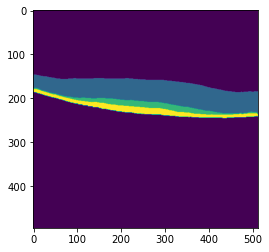

In [8]:
# verify prediction
plt.imshow(pred_diseased[40])

## Create Fig 3 for paper

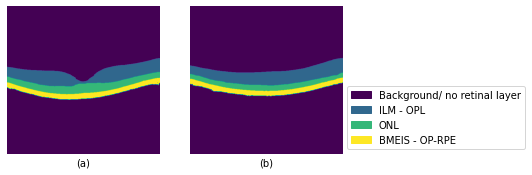

In [87]:

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.tick_params(left=False,
            bottom=False,
            labelleft=False,
            labelbottom=False)
ax2.tick_params(left=False,
            bottom=False,
            labelleft=False,
            labelbottom=False)
im1 = ax1.imshow(pred_healthy[49])
ax2.imshow(pred_healthy[15])
ax1.set_xlabel("(a)")
ax2.set_xlabel("(b)")
ax1.set_frame_on(False)
ax2.set_frame_on(False)
values = np.unique(pred_healthy[0])
colors = [ im1.cmap(im1.norm(value)) for value in values]
patches = [mpatches.Patch(color=colors[0], label="Background/ no retinal layer"),
           mpatches.Patch(color=colors[1], label="ILM - OPL"),
           mpatches.Patch(color=colors[2], label="ONL"),
           mpatches.Patch(color=colors[3], label="BMEIS - OP-RPE")]
# ax2.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend(handles=patches, loc='lower left', bbox_to_anchor=(1, 0))

plt.savefig(FIG_DIR / f"Figure 3.png", dpi=300, bbox_inches='tight')


## Thickness maps

In [10]:
# calculate the retinal thickenss map
map_healthy = Map(dicom_healthy, pred_healthy, dicom_healhty_path)
map_healthy_onl = Map(dicom_healthy, pred_healthy_onl, dicom_healhty_path)

map_diseased = Map(dicom_diseased, pred_diseased, dicom_diseased_path)
map_diseased_onl = Map(dicom_diseased, pred_diseased_onl, dicom_diseased_path)


In [11]:
# initialize calculation of thickness map
map_healthy.depth_grid((796, 796))
map_healthy_onl.depth_grid((796, 796))
map_diseased.depth_grid((796, 796))
map_diseased_onl.depth_grid((796, 796))

## Plot healthy thickness maps

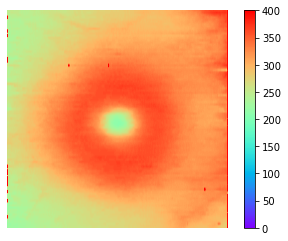

In [12]:
plt.figure( figsize = (5, 5) )

thickness_map_healthy = map_healthy.thickness_map
# crop black margin
thickness_map_healthy = map_healthy.crop_image(thickness_map_healthy, tol = 0)

thickness_map_healthy = np.ma.masked_where(thickness_map_healthy == 0,
                                    thickness_map_healthy)

cm_heidelberg = map_healthy.heidelberg_colormap()
plt.imshow(thickness_map_healthy, cmap = "rainbow", vmin=0, vmax=400)
plt.colorbar()
plt.axis("off")
plt.show()



## Plot ONL healthy

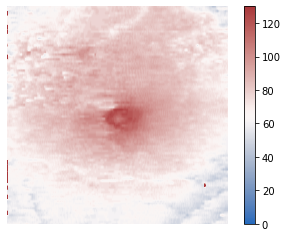

In [13]:
thickness_map_healthy_onl = map_healthy_onl.thickness_map
# crop black margin
thickness_map_healthy_onl = map_healthy_onl.crop_image(thickness_map_healthy_onl, tol = 0)

thickness_map_healthy_onl = np.ma.masked_where(thickness_map_healthy_onl == 0,
                                    thickness_map_healthy_onl)


cm_heidelberg = map_healthy.heidelberg_colormap()
plt.imshow(thickness_map_healthy_onl, cmap = sns.color_palette("vlag", as_cmap=True), vmin=0, vmax=130)
plt.colorbar()
plt.axis("off")
plt.show()


## Plot diseased all layers

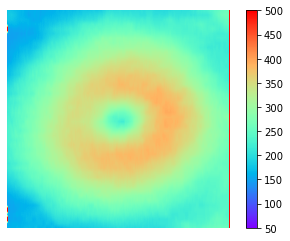

In [14]:
thickness_map_diseased = map_diseased.thickness_map
# crop black margin
thickness_map_diseased = map_diseased.crop_image(thickness_map_diseased, tol = 0)

thickness_map_diseased = np.ma.masked_where(thickness_map_diseased == 0,
                                            thickness_map_diseased)


cm_heidelberg = map_healthy.heidelberg_colormap()
#thickness_map_diseased[thickness_map_diseased > 500.0] = 1000
plt.imshow(thickness_map_diseased, cmap = "rainbow", vmin=50, vmax=500)#, vmin = 0, vmax=200 , )
plt.colorbar()
plt.axis("off")
plt.show()


## Plot diseased ONL

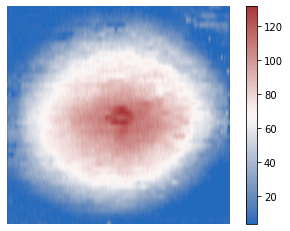

In [23]:
thickness_map_diseased_onl = map_diseased_onl.thickness_map
# crop black margin
thickness_map_diseased_onl = map_diseased_onl.crop_image(thickness_map_diseased_onl, tol = 0)

thickness_map_diseased_onl = np.ma.masked_where(thickness_map_diseased_onl == 0,
                                    thickness_map_diseased_onl)


cm_heidelberg = map_healthy.heidelberg_colormap()
thickness_map_diseased_onl[thickness_map_diseased_onl > 500.0] = 1000
cmap = cm_heidelberg
cmap.set_bad( color = 'black' )
# 
plt.imshow(thickness_map_diseased_onl, cmap = sns.color_palette("vlag", as_cmap=True))
plt.colorbar()
plt.axis("off")
plt.show()

## ETDRS: Healthy all layers

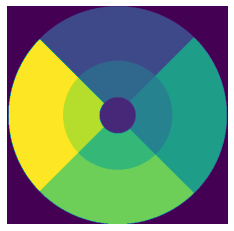

In [21]:
etdrs = ETDRSUtils("C:\\Users\\robin\\Desktop\\MASTER Mathematics in Data Science\\HiWi\\OCTdata\\gesunde_OCT\\3d_segmentation\\010101_20230510_1520_Spectralis_Bild_OD_1_Surfaces_Retina-JEI-Final_3d.npy")
# redcord_log = etdrs.get_etdrs_stats()
etdrs.height, etdrs.width = thickness_map_healthy.shape
etdrs.zones()

all_regions = np.zeros_like(etdrs.etdrs_bool_grid["C0"])

region_colors = sns.color_palette("colorblind").as_hex()[:9]
for idx, etdrs_region in enumerate(etdrs.etdrs_bool_grid.keys()):

    region = thickness_map_healthy * etdrs.etdrs_bool_grid[etdrs_region].astype(int)    
    all_regions = all_regions + etdrs.etdrs_bool_grid[etdrs_region].astype(int) * (idx+1)

    
plt.figure()
plt.imshow(all_regions)
# plt.colorbar()
plt.axis('off')
plt.savefig(FIG_DIR / f"etdrs_regions.png", dpi=300, transparent=True)

('ETDRS region:', 'C0', ', Average thickness: ', 274.0267545098039)
('ETDRS region:', 'S2', ', Average thickness: ', 301.93902888398355)
('ETDRS region:', 'S1', ', Average thickness: ', 354.4984206603152)
('ETDRS region:', 'N1', ', Average thickness: ', 352.49035211798997)
('ETDRS region:', 'N2', ', Average thickness: ', 325.43661961151906)
('ETDRS region:', 'I1', ', Average thickness: ', 352.8376813326219)
I2
('ETDRS region:', 'I2', ', Average thickness: ', 302.9005224486915)
('ETDRS region:', 'T1', ', Average thickness: ', 348.3089716028633)
('ETDRS region:', 'T2', ', Average thickness: ', 294.1205611727159)


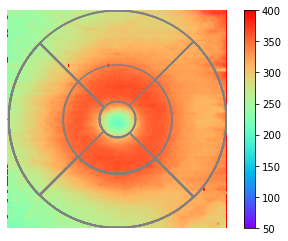

In [22]:
# for each etdrs region, get statistics
statement = []


all_regions = np.zeros_like(etdrs.etdrs_bool_grid["C0"])

for idx, etdrs_region in enumerate(etdrs.etdrs_bool_grid.keys()):

    region = thickness_map_healthy * etdrs.etdrs_bool_grid[etdrs_region].astype(int)
    # Sometimes the grey grid is plotted wrongly, small workaround
    if etdrs_region=="I2":
        print("I2")
        first_row = etdrs.etdrs_bool_grid["I2"][0,:]
        temp = np.delete(etdrs.etdrs_bool_grid["I2"], 0, 0)
        temp_new = np.concatenate([temp, np.expand_dims(first_row, axis=0)])
        all_regions = all_regions + temp_new.astype(int) * (idx+1)
    else:
        all_regions = all_regions + etdrs.etdrs_bool_grid[etdrs_region].astype(int) * (idx+1)
    region_none_0 = region[region!=0]
    txt = "ETDRS region:", etdrs_region, ", Average thickness: ", np.mean(region_none_0)
    statement.append(txt)
    print(txt)


x = np.linspace(0, thickness_map_healthy.shape[1], thickness_map_healthy.shape[1])
y = np.linspace(0,thickness_map_healthy.shape[0], thickness_map_healthy.shape[0])
X, Y = np.meshgrid(x, y)
plt.figure()
plt.imshow(thickness_map_healthy,cmap = sns.color_palette("rainbow", as_cmap=True), vmin=50, vmax=400)
plt.colorbar()
plt.axis('off')
plt.contour(X, Y, all_regions, 20, colors="gray")
plt.savefig(FIG_DIR / f"thickness_healthy_all.png", dpi=300)


## Diseased all layers

('ETDRS region:', 'C0', ', Average thickness: ', 280.17425379361265)
('ETDRS region:', 'S2', ', Average thickness: ', 270.28740745542945)
('ETDRS region:', 'S1', ', Average thickness: ', 360.7030782592762)
('ETDRS region:', 'N1', ', Average thickness: ', 369.05538531073444)
('ETDRS region:', 'N2', ', Average thickness: ', 309.69703978835423)
('ETDRS region:', 'I1', ', Average thickness: ', 366.9310982684379)
('ETDRS region:', 'I2', ', Average thickness: ', 279.6085928038898)
('ETDRS region:', 'T1', ', Average thickness: ', 344.6839117067402)
('ETDRS region:', 'T2', ', Average thickness: ', 276.50436936118007)


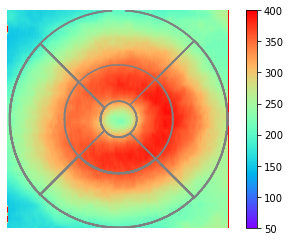

In [25]:
etdrs.height, etdrs.width = thickness_map_diseased.shape
etdrs.zones()


# for each etdrs region, get statistics
statement = []


all_regions = np.zeros_like(etdrs.etdrs_bool_grid["C0"])

for idx, etdrs_region in enumerate(etdrs.etdrs_bool_grid.keys()):
    region = thickness_map_diseased * etdrs.etdrs_bool_grid[etdrs_region].astype(int)
    # Sometimes the grey grid is plotted wrongly, small workaround
    if etdrs_region=="I2":
        first_row = etdrs.etdrs_bool_grid["I2"][0,:]
        temp = np.delete(etdrs.etdrs_bool_grid["I2"], 0, 0)
        temp_new = np.concatenate([temp, np.expand_dims(first_row, axis=0)])
        all_regions = all_regions + temp_new.astype(int) * (idx+1)
    else:
        all_regions = all_regions + etdrs.etdrs_bool_grid[etdrs_region].astype(int) * (idx+1)
    region_none_0 = region[region!=0]
    txt = "ETDRS region:", etdrs_region, ", Average thickness: ", np.mean(region_none_0)
    statement.append(txt)
    print(txt)
x = np.linspace(0, thickness_map_diseased.shape[1], thickness_map_diseased.shape[1])
y = np.linspace(0,thickness_map_diseased.shape[0], thickness_map_diseased.shape[0])
X, Y = np.meshgrid(x, y)
plt.figure()

plt.imshow(thickness_map_diseased,cmap ="rainbow", vmin=50, vmax=400)#sns.color_palette("vlag", as_cmap=True))
plt.colorbar()
plt.axis('off')

plt.contour(X, Y, all_regions, 20, colors="gray", )#, colors=['r','g']);
plt.savefig(FIG_DIR / f"thickness_diseased_all.png", dpi=300)
plt.show()

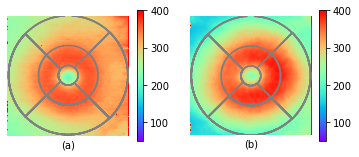

In [26]:
# create one plot for paper
fig, (ax1, ax2) = plt.subplots(1, 2)

a1 = ax1.imshow(thickness_map_healthy, cmap ="rainbow", vmin=50, vmax=400)
fig.colorbar(a1, ax=ax1, shrink=0.6)
ax1.contour(X, Y, all_regions, 20, colors="gray", )

a2 = ax2.imshow(thickness_map_diseased,cmap ="rainbow", vmin=50, vmax=400)
fig.colorbar(a2, ax=ax2, shrink=0.6)
ax2.contour(X, Y, all_regions, 20, colors="gray", )


ax1.tick_params(left=False,
            bottom=False,
            labelleft=False,
            labelbottom=False)
ax2.tick_params(left=False,
            bottom=False,
            labelleft=False,
            labelbottom=False)

ax1.set_xlabel("(a)")
ax2.set_xlabel("(b)")
ax1.set_frame_on(False)
ax2.set_frame_on(False)

plt.savefig(FIG_DIR / f"thickness_all_final.png", dpi=700, transparent=True)


## Healthy ONL

('ETDRS region:', 'C0', ', Average thickness: ', 109.0680377918552)
('ETDRS region:', 'S2', ', Average thickness: ', 80.97677884453427)
('ETDRS region:', 'S1', ', Average thickness: ', 88.47573362094792)
('ETDRS region:', 'N1', ', Average thickness: ', 94.70196389412907)
('ETDRS region:', 'N2', ', Average thickness: ', 75.37557520526308)
('ETDRS region:', 'I1', ', Average thickness: ', 88.07591506313355)
('ETDRS region:', 'I2', ', Average thickness: ', 68.01265676319551)
('ETDRS region:', 'T1', ', Average thickness: ', 89.25273327108621)
('ETDRS region:', 'T2', ', Average thickness: ', 76.5522661041092)


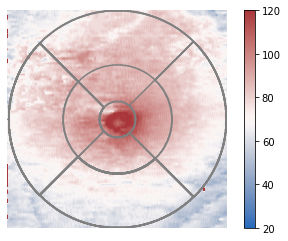

In [27]:
# redcord_log = etdrs.get_etdrs_stats()
etdrs.height, etdrs.width = thickness_map_healthy.shape
etdrs.zones()
# for each etdrs region, get statistics
statement = []

all_regions = np.zeros_like(etdrs.etdrs_bool_grid["C0"])

for idx, etdrs_region in enumerate(etdrs.etdrs_bool_grid.keys()):
    region = thickness_map_healthy_onl * etdrs.etdrs_bool_grid[etdrs_region].astype(int)
    # Sometimes the grey grid is plotted wrongly, small workaround
    if etdrs_region=="I2":
        first_row = etdrs.etdrs_bool_grid["I2"][0,:]
        temp = np.delete(etdrs.etdrs_bool_grid["I2"], 0, 0)
        temp_new = np.concatenate([temp, np.expand_dims(first_row, axis=0)])
        all_regions = all_regions + temp_new.astype(int) * (idx+1)
    else:
        all_regions = all_regions + etdrs.etdrs_bool_grid[etdrs_region].astype(int) * (idx+1)
    region_none_0 = region[region!=0]
    txt = "ETDRS region:", etdrs_region, ", Average thickness: ", np.mean(region_none_0)
    statement.append(txt)
    print(txt)

x = np.linspace(0, thickness_map_healthy.shape[1], thickness_map_healthy.shape[1])
y = np.linspace(0,thickness_map_healthy.shape[0], thickness_map_healthy.shape[0])
X, Y = np.meshgrid(x, y)
plt.figure()

plt.imshow(thickness_map_healthy_onl,cmap ="vlag", vmin=20, vmax=120)#sns.color_palette("vlag", as_cmap=True))
plt.colorbar()
plt.axis('off')

plt.contour(X, Y, all_regions, 20, colors="gray", )
plt.savefig(FIG_DIR / f"thickness_healthy_onl.png", dpi=300, transparent=True)
plt.show()


## Diseased ONL layer

('ETDRS region:', 'C0', ', Average thickness: ', 114.4928508030275)
('ETDRS region:', 'S2', ', Average thickness: ', 34.409393452188006)
('ETDRS region:', 'S1', ', Average thickness: ', 79.41877533669262)
('ETDRS region:', 'N1', ', Average thickness: ', 94.31503126177024)
('ETDRS region:', 'N2', ', Average thickness: ', 48.05249393090081)
('ETDRS region:', 'I1', ', Average thickness: ', 92.62762774163994)
('ETDRS region:', 'I2', ', Average thickness: ', 40.61753767693139)
('ETDRS region:', 'T1', ', Average thickness: ', 90.52367489160426)
('ETDRS region:', 'T2', ', Average thickness: ', 48.62199075370159)


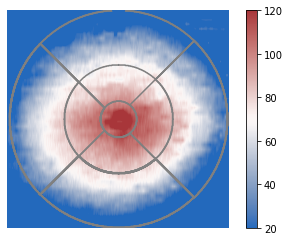

In [28]:
etdrs = ETDRSUtils("C:\\Users\\robin\\Desktop\\MASTER Mathematics in Data Science\\HiWi\\OCTdata\\gesunde_OCT\\3d_segmentation\\on_1_20010101_20230510_1520_Spectralis_Bild_OD_1_Surfaces_Retina-JEI-Final_3d.npy")
# redcord_log = etdrs.get_etdrs_stats()
etdrs.height, etdrs.width = thickness_map_diseased.shape
etdrs.zones()
# for each etdrs region, get statistics
statement = []


all_regions = np.zeros_like(etdrs.etdrs_bool_grid["C0"])

for idx, etdrs_region in enumerate(etdrs.etdrs_bool_grid.keys()):
    region = thickness_map_diseased_onl * etdrs.etdrs_bool_grid[etdrs_region].astype(int)
    # Sometimes the grey grid is plotted wrongly, small workaround
    if etdrs_region=="I2":
        first_row = etdrs.etdrs_bool_grid["I2"][0,:]
        temp = np.delete(etdrs.etdrs_bool_grid["I2"], 0, 0)
        temp_new = np.concatenate([temp, np.expand_dims(first_row, axis=0)])
        all_regions = all_regions + temp_new.astype(int) * (idx+1)
    else:
        all_regions = all_regions + etdrs.etdrs_bool_grid[etdrs_region].astype(int) * (idx+1)
    region_none_0 = region[region!=0]
    txt = "ETDRS region:", etdrs_region, ", Average thickness: ", np.mean(region_none_0)
    statement.append(txt)
    print(txt)
x = np.linspace(0, thickness_map_diseased_onl.shape[1], thickness_map_diseased_onl.shape[1])
y = np.linspace(0,thickness_map_diseased_onl.shape[0], thickness_map_diseased_onl.shape[0])
X, Y = np.meshgrid(x, y)
plt.figure()

plt.imshow(thickness_map_diseased_onl,cmap ="vlag", vmin=20, vmax=120)#sns.color_palette("vlag", as_cmap=True))
plt.colorbar()
plt.axis('off')

plt.contour(X, Y, all_regions, 20, colors="gray", )#, colors=['r','g']);

plt.savefig(FIG_DIR / f"thickness_diseased_onl.png", dpi=300, transparent=True)
plt.show()

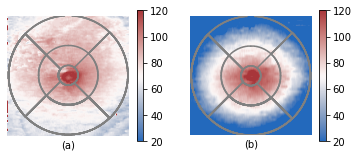

In [29]:
# create one plot for paper
fig, (ax1, ax2) = plt.subplots(1, 2)

a1 = ax1.imshow(thickness_map_healthy_onl,cmap ="vlag", vmin=20, vmax=120)
fig.colorbar(a1, ax=ax1, shrink=0.6)
ax1.contour(X, Y, all_regions, 20, colors="gray", )

a2 = ax2.imshow(thickness_map_diseased_onl,cmap ="vlag", vmin=20, vmax=120)
fig.colorbar(a2, ax=ax2, shrink=0.6)
ax2.contour(X, Y, all_regions, 20, colors="gray", )


ax1.tick_params(left=False,
            bottom=False,
            labelleft=False,
            labelbottom=False)
ax2.tick_params(left=False,
            bottom=False,
            labelleft=False,
            labelbottom=False)

ax1.set_xlabel("(a)")
ax2.set_xlabel("(b)")
ax1.set_frame_on(False)
ax2.set_frame_on(False)

plt.savefig(FIG_DIR / f"thickness_onl_final.png", dpi=700, transparent=True)
